# Модель определения рыночной стоимости автомобиля

## Цель реализации проекта:

> Разработать модель градиентного бустинга для определения рыночной стоимости автомобиля.

Критерии качества работы модели следующие:
- значение RMSE (среднеквадратичная ошибка);
- скорость предсказания;
- время обучения.

Алгоритм выполнения проекта следующий:
- освоить библиотеку LightGBM и понять, в каком виде нам потребуются входные данные для построения модели;
- изучить и подготовить входные данные (почему они на втором месте я написал выше);
- понять, какие гиперпараметры мы можем подбирать (и какие стоит подбирать) и подобрать их - с целью максимизации критериев качества конечной модели;
- предложить несколько вариантов возможной конечной модели (при необходимости и возможности).

### Импорт библиотек

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ох уж эти предупреждения!
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from  sklearn.ensemble import RandomForestRegressor

# 1. Подготовка данных

In [2]:
# data_raw = pd.read_csv('/datasets/autos.csv')
data_raw = pd.read_csv('autos.csv')
data_raw_amount = data_raw['Price'].count()
data_raw

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


15 признаков + 1 целевой. По списку:
- DateCrawled — дата скачивания анкеты из базы. Убираем. Для модели не понадобится;
- VehicleType — тип автомобильного кузова. Вполне себе признак - помним, что ролс-ройс выпускает ещё и кроссоверы (!);
- RegistrationYear — год регистрации автомобиля. Предполагаем, что год регистрации = году выпуска автомобиля. Случаи расхождения этих значений сомнительны - купил до НГ, зарегистрировал после? Не знаю как работает эта система - пока оставлю как есть. Признак тоже оставляем;
- Gearbox — тип коробки передач - нужно;
- Power — мощность (л. с.) - нужно;
- Model — модель автомобиля - нужно;
- Kilometer — пробег (км) - нужно;
- RegistrationMonth — месяц регистрации автомобиля - а вот неободимость этого признака я ставлю под сомнение, т.к. месяц регистрации важен (с точки зрения возраста автомобиля) только в первые 2 года его жизни. 
> Как у маленьких детей: "Я страше тебя на полгода, поэтому гони сюда все свои конфеты, малолетка!"

Соответственно, я не вижу смысла оставлять месяц регистрации (в отличие от года) для обучения модели;
- FuelType — тип топлива - бензин, дизель, на газу - оставляем;
- Brand — марка автомобиля - нужно;
- NotRepaired — была машина в ремонте или нет - не бит, не крашен, родные колёса - оставляем;
- DateCreated — дата создания анкеты - удаляем;
- NumberOfPictures — количество фотографий автомобиля - сомнительный критерий для определения цены автомобиля. Если бы разрабатывали рекомендательную систему для сайта - тогда да, количество и качество фотографий - важные критерии успешной (и, возможно, несколько большей цены) продажи чего угодно. Но у нас - только расчет прогнозной рыночной стоимости - фото нам здесь ни к чему;
- PostalCode — почтовый индекс владельца анкеты (пользователя) - теоретически, данный признак может быть использован для оценки - например, с точки зрения агрессивности климатической зоны, в которой эксплуатировался транспорт (например, нельзя без соответствующей корректировки сравнивать условия Норильска и какого-нибудь Геленджика - разные климаты, разное воздействие на рабочие части авто, краску и т.п.). Однако, как это привязать в наших условиях - не совсем ясно. Например, можно было бы попробовать разделить их в соответствии с агрессивностью климата по ГОСТ 9.039-74 и использовать в качестве категориального признака. Но - "нет ручек, нет конфетки". В другой раз)
- LastSeen — дата последней активности пользователя - также лишний параметр, не имеющий к цене автомобиля прямого (или косвенного с достаточной степенью влияния) отношения.

Расчистим признаки от "нахлебников", коих у нас оказалось целых 6 штук и смотрим на распределения данных.

In [3]:
data_clmns = data_raw.drop(['DateCrawled', 'RegistrationMonth',
                            'NumberOfPictures', 'PostalCode',
                           'LastSeen', 'DateCreated'], axis = 1)
data_clmns

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


## Предобработка данных. 

В столбцах также видны пропуски. Пройдемся по ним и подумаем, что можно с ними сделать. Начнем с целевого признака. Пропуски здесь не восстановимы, поэтому - как и с нулевыми значениями выход один - удалять. Посмотрим, сколько их всего на 354+ тысячи объектов и сколько мы понесём потерь вследствие их удаления. Построим гистограмму. Она также "укажет" нам на корректность распределения значений признака. 

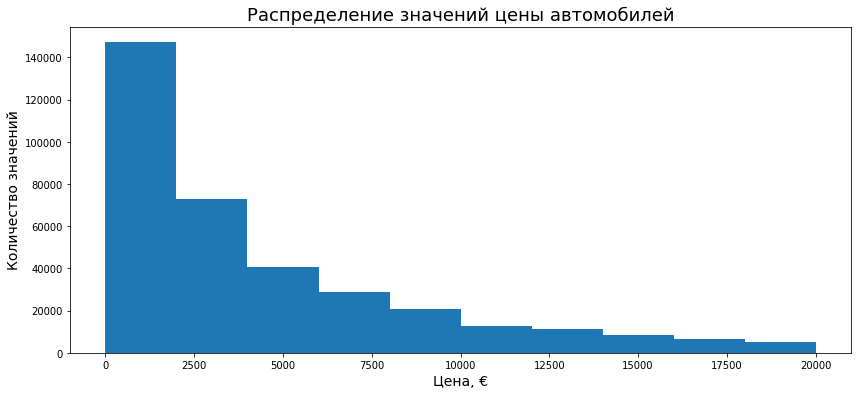

Wall time: 339 ms


In [4]:
%%time
plt.figure(figsize = (14,6))
plt.hist(data_clmns['Price'], bins = 10)
plt.title('Распределение значений цены автомобилей', fontsize = 18)
plt.xlabel('Цена, €', fontsize = 14)
plt.ylabel('Количество значений', fontsize = 14)
plt.show()

Поднесем наш микроскоп к нулю.

In [5]:
data_clmns[data_clmns['Price'] == 0]['Price'].count()

10772

In [6]:
data_clmns[data_clmns['Price'].isna() == True]['Price'].count()

0

Около 11 тысяч значений - нули. А вот пропусков - ни одного. Мы можем удалить пропуски сразу и нам за это даже ничего не будет. Но, как человеку, настроенному на долговременное и продуктивное сотрудничество, мне важно понять возможные причины возникновения таких данных. Да, 3%. Да, "мало". В масштабах миллиардных бюджетов это внезапно становится "много". Смотрим.

In [7]:
data_clmns[data_clmns['Price'] == 0].head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,NaN,2006,NaN,0,other,5000,NaN,fiat,NaN
231,0,wagon,2001,manual,115,mondeo,150000,NaN,ford,NaN
334,0,NaN,2005,NaN,0,polo,150000,petrol,volkswagen,NaN
415,0,NaN,1985,NaN,0,3er,150000,NaN,bmw,NaN
466,0,NaN,2016,auto,197,3er,150000,gasoline,bmw,no


На первый взгляд никаких общих и выделяющихся моментов я не вижу, поэтому "вырежем" нулевые значения в отдельный датасет и "побалуемся" с ними ближе к концу анализа - когда будет известен характер распределения прочих признаков.

In [8]:
data_zero_price = data_clmns[data_clmns['Price'] == 0]

Следующий на очереди - "Тип транспортного средства". Признак категориальный - смотрим на число пропусков и какие категории присутствуют.

In [9]:
data_price = data_clmns[data_clmns['Price'] != 0]
print("Nan", data_price['Price'].count() - data_price['VehicleType'].value_counts().sum())
data_price['VehicleType'].value_counts()

Nan 33750


sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

В наличии седаны, "малолитражки", универсалы, автобусы (ого!), кабриолеты, купе, suv-ы («спортивно-утилитарные автомобили» типа Нивы, крузака и т.п.) и подгруппа "других". Плюс 33.75 тысяч NAN-ов.

Резонный вопрос - что делать с пропусками? Удалить? Отнести в группу "другие"? По некоторой логике заменить имеющимися значениями в определенном соотношении? 

Все версии, в той или иной степени осуществимы. Вопрос в другом - какой подойдет нам. Посмотрим на объекты с пропусками в "типе транспортного средства" и решим, что же нам с ними сделать, не нарушая логики распределения значений и не внося путаницы (и прочих проблем) в работа будующей модели. 

In [10]:
data_price[data_price['VehicleType'].isna() == True]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no


Для того, чтобы понимать причину появления этих пропусков, нам необходимо понимать КАК эти данные вообще появляются. Для этого, давайте проанализируем, чем занимается компания. 

>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Итак - СЕРВИС по ПРОДАЖЕ автомобилей с пробегом. Стало быть, в него каким-то образом поступают данные об автомобиле - они выкупают их у бывших владельцев и т.п. (это не суть важно). Однако, скорее всего, представленные ДАННЫЕ заполняются ПРЕДСТАВИТЕЛЯМИ компании, а не её участниками - как я могу продавать ситроен С4, если я даже не знаю, в каком типе кузова он представлен. Следовательно эти данные выглядят странно и не совсем отвечают логике существования компании. 

Они куда больше похожи (учитывая наличие пропусков) на данные, которые заполняются клиентами - например людьми, вроде меня - которые просто ездят на машине, не особо понимают какой это кузов, сколько тут лошадей и т.д. Но знают, что это мерседес 2018 года выпуска. Т.е. таких автомобильных "профанов", которым не интересно заниматься машиной (в отличие от моего отца), для которых она - пассив (ест деньги + дешевеет) и средство (можно на ней куда-то поехать), а не любовь всей жизни и способ упорядочить свободное время (копаться в ней, что-то разбирать и т.д.).

Итак, чтоже делать с пропусками в категориальных переменных?

1. Удалить
> Плюсы - быстро, дешево и сердито. Минусы - потеря данных.
2. Как-то заполнить - например, неким индикаторным значением.
> Плюсы - данные снова с нами. Минусы - непонятно, что-как-куда и каким образом + появится дополнительный класс, который точно внесет свои "моменты" в точность итогового прогнозирования.

Удалять объекты с пропусками мы не можем. Логики "непосредственной" замены я не вижу, но вот вариант с заменой пропусков на "other" выглядит достаточно перспективно. Ведь почти наверняка, среди уже существующих объектов, помеченных как "другие", есть и представители кабриолетов, СУВ-ов, малолитражек и прочих. Опять же, в силу озвученной мной ранее логики про водителей-любителей.

Единственный момент, который следует предусмотреть, прежде чем начинать замены пропусков - это посмотреть, сколько у нас т.н. "безнадежных" объектов - т.е. тех, в которых пропущена большая часть признаков, а значит восстановление данных объектов не имеет большого смысла ввиду крайне высокого риска "неточности" восстановления. 

Для этого посчитаем, сколько у нас типов объектов по числу пропусков.

In [11]:
target = data_price['Price']
features = data_price.drop(['Price'], axis = 1)

In [12]:
def nan_count(row):
    nan_number = 0
    for element in row:
        if element == 999999:
            nan_number += 1
    return nan_number

features_nan = features.fillna(999999)
features_nan['nan_number'] = features_nan.apply(nan_count, axis = 1)
features_nan['nan_number'].value_counts()

0    242428
1     61456
2     24426
3      9009
4      4774
5      1504
Name: nan_number, dtype: int64

Итак, почти 242000 объектов - без пропусков от слова "вообще". Неплохо. Примерно 2/3 от всего объема данных. Будем это иметь в виду. При этом объектов с 3-4-5 пропусками практически нет - суммарно 15 тысяч значений на весь датасет. Думаю, что будет адекватно убрать объекты, в которых больше трети признаков "взяты с потолка" (логично взяты с потолка, но всё-таки). 

После устранения "безвозвратных объектов", заполним пропуски в столбце "VehicleType" на "other" и обратимся к оставшимся столбцам.

In [13]:
features_below = features_nan[features_nan['nan_number'] < 3]
features_below = features_below.drop(['nan_number'], axis = 1)
features_below

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,999999,1993,manual,0,golf,150000,petrol,volkswagen,999999
1,coupe,2011,manual,190,999999,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354363,bus,2000,manual,0,zafira,150000,petrol,opel,no
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [14]:
features_below['VehicleType'] = features_below['VehicleType'].replace(999999, 'other')
features_below['VehicleType'].value_counts()

sedan          88909
small          77318
wagon          63300
bus            28179
other          23712
convertible    19692
coupe          15497
suv            11703
Name: VehicleType, dtype: int64

Позиция "другие" "поднялась" по отношению к другим - теперь вместо 3 тысяч значений мы наблюдаем 23 тысячи. Как это повлияет на качество обучения модели? Узнаем через несколько часов! Не переключайтесь!

На очереди - год регистрации транспортного средства. Для нас год регистрации напрямую совпадает с годом выпуска, поэтому данный признак и так важен. Посмотрим, что у нас здесь.

In [15]:
np.sort(features_below['RegistrationYear'].unique())

array([1000, 1400, 1600, 1602, 1910, 1923, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2900,
       3700, 4000, 5000, 6000, 6500], dtype=int64)

Всё, что ниже 1923 и выше 2019 года - под нож. Ошибка в данном столбце недопустима.

In [16]:
features_year = features_below[(features_below['RegistrationYear'] > 1920) & (features_below['RegistrationYear'] < 2020)]
np.sort(features_year['RegistrationYear'].unique())

array([1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019], dtype=int64)

Готово. Следующий в очереди - тип коробки передач. Насколько мне известно, основных вариантов 2 - ручная (мануал) и автоматическая (авто). Ещё знаю про некий вариатор, однако, что у нас будет на практике - сейчас увидим.

In [17]:
features_year['Gearbox'].value_counts()

manual    255898
auto       63806
999999      8574
Name: Gearbox, dtype: int64

Учитывая, что других типов коробок кроме "автомата" и "ручной" мы не встретили - вполне вероятно, что форма сбора данных их попросту не содержит. Стало быть это может быть одна из точек роста и повышения точности прогнозирования (и, что куда важнее - лояльности покупателей. Да, нишевый момент, да, небольшая доля рынка. Но тем не менее - 3% есть 3%) - ввести альтернативные варианты коробок передач. Однако в нашем случае, мы удаляем данные объекты без зазрения совести. Почему? Потому что введение нового класса только "запутает" модель, а распределить их по "ручному" и "автомату" способом, не требующим колоссальных затрат времени и ресурсов (а он, почти наверняка, есть), не представляется возможным. По крайней мере я такого пока не знаю. 

Следовательно - удаляем и идём дальше. Минус ещё 3% данных.

In [18]:
features_gearbox = features_year[features_year['Gearbox'] != 999999]
features_gearbox

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,other,1993,manual,0,golf,150000,petrol,volkswagen,999999
1,coupe,2011,manual,190,999999,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354363,bus,2000,manual,0,zafira,150000,petrol,opel,no
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Мощность. До какого-то момента я совершенно не понимал, зачем люди создают машины в которых по 500+ лошадиных сил и которые могут ездить со скоростью 200+ км/час, если "разрешенная" - максимум 140 и то, на трассе. Но потом я понял что-то про себя и мне полегчало)

Перед нами же стоит вопрос не огромной мощности, а, скорее, её отсутствия - что делать с объектами, для которых мощность = 0 л.с.?

Варианты те же - удалять или заменять.

Посмотрим на распределение значений мощности для имеющихся данных и подумаем над возможными вариантами заполнения пропусков. 

In [19]:
features_gearbox['Power'].describe()

count    319704.000000
mean        115.333502
std         187.525040
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Минута воспоминаний о "Высоцком" - "лошадей двадцать тысяч в машины зажаты". Но учитывая, что среднее 115, а медиана 105 - я крайне сомневаюсь, что нам следует оставлять объекты с ТАКОЙ мощностью в нашем распределении. Посмотрим на уникальные значения мощности.

In [20]:
features_gearbox['Power'].sort_values(ascending = False).head(30)

219584    20000
299180    19312
114106    19211
132485    19208
63986     17932
196532    17700
150676    17410
187330    17019
175422    17011
216993    16312
311399    16311
181311    16051
248569    16011
205808    15033
148466    15020
260799    15017
162214    15001
270948    14009
227634    13636
187971    12684
346639    12512
292167    12512
253791    12512
77779     12510
62975     12012
100680    11635
56971     11530
98619     11509
262668    11025
197896    11011
Name: Power, dtype: int64

Причин возникновения столь большой мощности также весьма много - начиная от банального "Это реальное положение дел!" до неверной конвертации в лошадиные силы и т.д. Однако, поскольку их меньшинство, нам придётся ограничить себя некоторым "потолковым" значением, чтобы не "поломать" качество модели оценки.

Для этого посмотрим на распределение значений в диапазоне 0-1000 л.с.

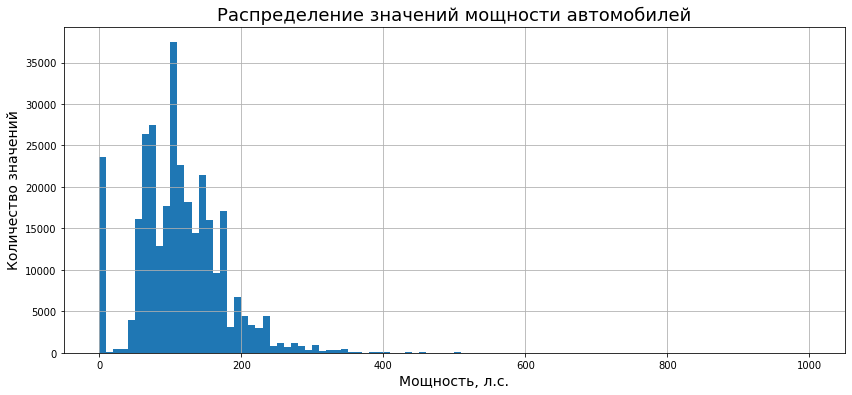

In [21]:
plt.figure(figsize = (14,6))
features_gearbox['Power'].hist(range = (0,1000), bins = 100)
plt.title('Распределение значений мощности автомобилей', fontsize = 18)
plt.xlabel('Мощность, л.с.', fontsize = 14)
plt.ylabel('Количество значений', fontsize = 14)
plt.show()

Уменьшим диапазон, т.к. после ~400 л.с. значений практически нет (в общем масштабе гистограммы).

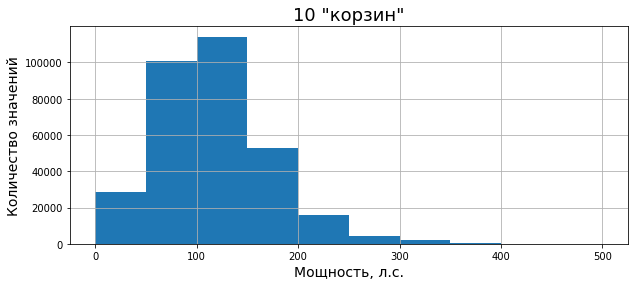

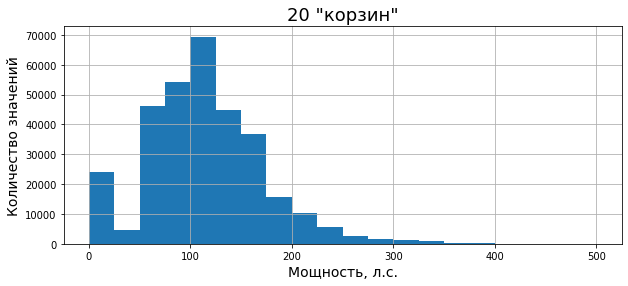

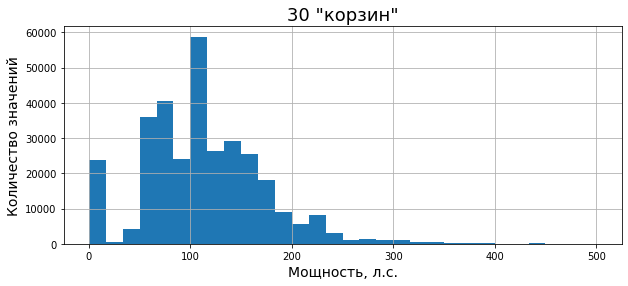

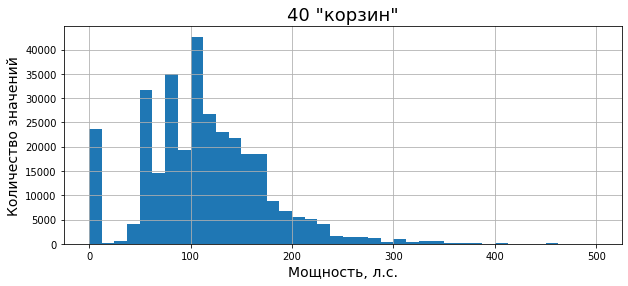

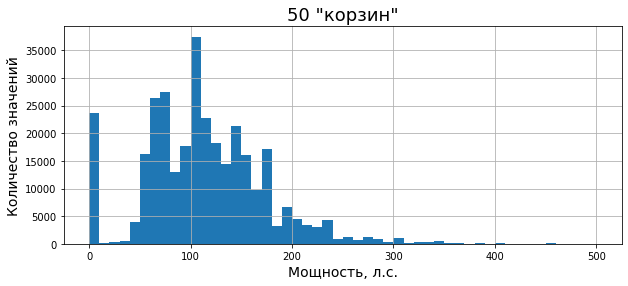

In [22]:
for bins_number in range(10,60,10):
    plt.figure(figsize = (10,4))
    features_gearbox['Power'].hist(range = (0,500), bins = bins_number)
    plt.title(str(bins_number) + ' "корзин"', fontsize = 18)
    plt.xlabel('Мощность, л.с.', fontsize = 14)
    plt.ylabel('Количество значений', fontsize = 14)
    plt.show()

Наиболее информативно, на мой взгляд, распределение с "корзинами", весом по 10 л.с. (50 "корзин"). Взглянем на него ещё раз.

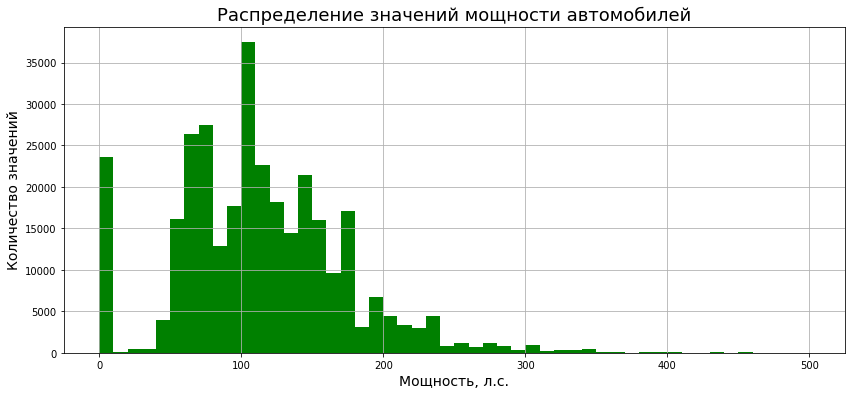

In [23]:
plt.figure(figsize = (14,6))
features_gearbox['Power'].hist(range = (0,500), bins = 50, color = 'green')
plt.title('Распределение значений мощности автомобилей', fontsize = 18)
plt.xlabel('Мощность, л.с.', fontsize = 14)
plt.ylabel('Количество значений', fontsize = 14)
plt.show()

Нормальным данное распределение не назовёшь, а вот группой совмещенных нормальных распределений - вполне. "На глаз", можно выделить группы со средней мощностью в районе 60-70, 100, 140, 170, 190 и 240 лс. Причем "высота" ряда пиков на гистограмме скорее всего "задрана так высоко" за счёт смежных распределений - то, что у вас считается средним, у нас - МАКСИМУМ. 

Полагаю, данное сочленение нормальных распределений вызвано, в первую очередь, существование неписанного (или писанного?) распределения автомобилей по классам - эконом, супер-эконом, бизнес, премиум и т.д. 

Следовательно и выпускают автомобили по соответствующей логике - под людские задачи - кому-то картошку везти, а кому-то себя. Но это не так важно. Нам необходимо решить, что делать с нашим распределением - как убрать нули и "ОГРОМНЫЕ" артефакты. 


Для начала уберем нулевые значения и посмотрим, по какому значению проходят "границы" (среднего+3 стандартных отклонений) и решим что делать дальше.

In [24]:
features_test_power = features_gearbox[features_gearbox['Power'] != 0]
features_test_power

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,999999,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,999999,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


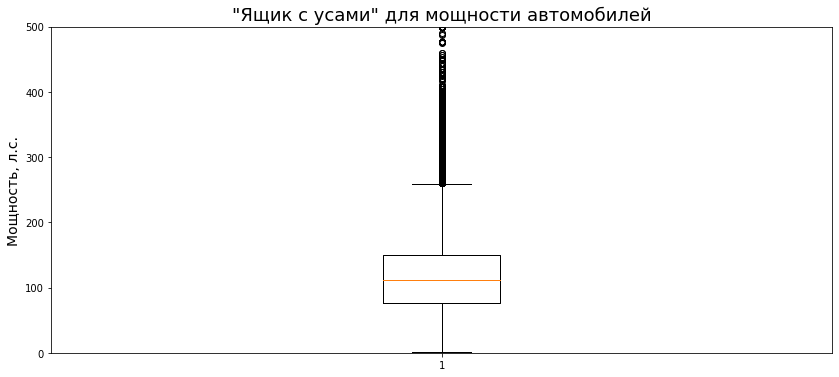

In [25]:
plt.figure(figsize = (14,6))
plt.boxplot(x = features_test_power['Power'])
plt.title('"Ящик с усами" для мощности автомобилей', fontsize = 18)
plt.ylabel('Мощность, л.с.', fontsize = 14)
plt.ylim(0,500)
plt.show()

In [26]:
features_test_power['Power'].quantile(0.99)

306.0

99% значений - до 306 л.с.
Посмотрим, сколько при таком раскладе мы "выбросим" объектов.

In [27]:
features_test_power[features_test_power['Power'] > 306]['Power'].count()

2510

Думаю, что нас такая точность более чем удовлетворит. Значения выше 99 квантиля отбрасываем, а всё остальное - оставляем. Они пригодятся нам для сбора версий относительно нулевых значений.

In [28]:
features_power = features_test_power[features_test_power['Power'] <= 306]
features_power

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,999999,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,999999,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Ситуация "осложняется" тем, что у нас нет иных подходящих количественных признаков, на основании которых мы могли бы посредством обратной корреляции восстановить значения мощности. 

Из количественных только год и пробег, причем ни один из них не подходит для корреляции с точки зрения дискретности и диапазона распределения значений. Тем не менее, посмотрим на точечную диаграмму распределения значений мощности в завиисомсти от года выпуска - возможно, это укажет нам путь :)

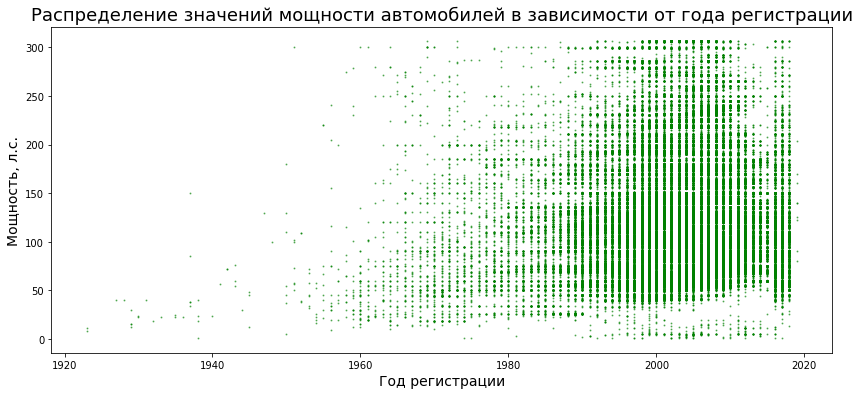

In [29]:
plt.figure(figsize = (14,6))
plt.scatter('RegistrationYear', 'Power', data = features_power, s = 1, alpha = 0.5, color = 'green')
plt.title('Распределение значений мощности автомобилей в зависимости от года регистрации', fontsize = 18)
plt.xlabel('Год регистрации', fontsize = 14)
plt.ylabel('Мощность, л.с.', fontsize = 14)
plt.show()

Наблюдая полученную диаграмму, с одной стороны, я понимаю, что некоторая зависимость мощности от года регистрации Т.С. (года выпуска) точно есть - так, до 1960 года автомобили мощностью 100+ л.с. - редкая редкость. Точно также как для 1980 года - мощность 200 л.с.

И тем не менее, прямых способов восстановления пропусков в мощности через год выпуска я не вижу.

Однако, все же хорошо, что я построил этот график. Теперь я отчетливо вижу то, что "забыл" ранее - а именно "аномальность" и "артефактность" объектов, со значениями даты 1920-1960. Почему это так? Потому что, учитывая, что признаки будут "нормализовываться", с таким распределением по году, у нас получится много БОЛЬШИХ значений (около 1) и совсем чуть-чуть маленьких - около нуля. Следовательно, корректность обучения и дальнейшего прогнозирования модели в таком случае ставится под вопрос. 

По аналогии с мощностью, обрежем объекты типа "древний транспорт" с помощью "усатого ящика".

In [30]:
features_power['RegistrationYear'].quantile(0.01)

1983.0

1983 гол - планка 1% всех значений. Удалим, всё что ниже не задумываясь. Нули в мощности также "отпускаем и забываем" (привет мультфильму "Холодное сердце"). 

На нашем пути "МОДЕЛЬ".

In [31]:
features_power_year = features_power[features_power['RegistrationYear'] >= 1983]
features_power_year

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,999999,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,999999,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [32]:
features_power_year['Model'].value_counts().count()

249

249 разных моделей. Среди них точно есть пропуски с индикаторными девятками (999999). А вот есть ли значения типа "other"? Узнаем.

In [33]:
features_power_year[features_power_year['Model'] == 'other']['Model'].count()

18698

Да и достаточно много. А пропусков?

In [34]:
features_power_year[features_power_year['Model'] == 999999]['Model'].count()

8515

Тоже довольно много. Думаю, что замена в этом случае - достаточно подхоядщий вариант, т.к. на фоне 249 моделей, доминация группы 'other' не сильно изменится. Было (18700 / 300 000 =) 6% общей массы, стало (18700 + 8500) 9%. В масштабах всего признака - не смертельно.

In [35]:
features_model = features_power_year.copy()
features_model['Model'] = features_model['Model'].replace(999999, 'other')
features_model[features_model['Model'] == 999999]['Model'].count()

0

In [36]:
features_model

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,999999
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,999999,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Теперь километраж.

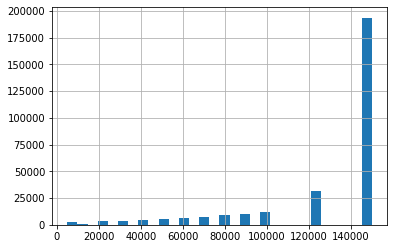

In [37]:
features_model['Kilometer'].hist(bins = 30)

Очевидно, что несмотря на вид "количественности", данный признак скорее категориальный. Почему? На лицо явно выраженная "дискретность" значений с шагом в 10 000 км до границы в 100 тыс. километров и далее 25 000 до границы в 150 тысяч. 
Почему? Потому что такая форма на сайте. Пропусков не видно (привет 999999 километров пробега и 1 км до перелистывания одометра).

Тут нам делать нечего. Тип топлива на очереди.

In [38]:
features_model['FuelType'].value_counts()

petrol      184119
gasoline     87841
999999       13684
lpg           4494
cng            492
hybrid         202
other           77
electric        69
Name: FuelType, dtype: int64

Продолжаем с брендом.

In [39]:
features_model['Brand'].value_counts()

volkswagen        63699
opel              32200
bmw               31576
mercedes_benz     26402
audi              25090
ford              20437
renault           14009
peugeot            9273
fiat               7511
seat               5947
skoda              4954
mazda              4709
citroen            4208
nissan             4019
toyota             3994
smart              3853
hyundai            3116
mini               2983
volvo              2757
mitsubishi         2491
honda              2360
kia                2102
suzuki             1945
alfa_romeo         1909
chevrolet          1355
sonstige_autos     1223
chrysler           1126
dacia               811
subaru              631
daihatsu            607
jeep                540
saab                467
land_rover          442
daewoo              410
porsche             396
jaguar              387
lancia              369
rover               356
trabant             175
lada                139
Name: Brand, dtype: int64

Пропусков нет, однако "Лады", "Трабанты" и "роверы" несколько "напрягают". Чем? Их крайне мало, следовательно, они скорее "шум", чем "важные" данные. Важные, с точки зрения "будущего качества модели". 

Но я их всё же оставлю.

Время ремонта!

In [40]:
features_model['NotRepaired'].value_counts()

no        223077
999999     39378
yes        28523
Name: NotRepaired, dtype: int64

Предположу, что, учитывая, что у нас сервис автомобилей с пробегом, скорее "НЕТ" - это относится к авто, которые хоть раз но РЕМОНТИРОВАЛИ. А "ДА" - к тем, которые ранее НЕ РЕМОНТИРОВАЛИ. 

Таким образом, пропуски здесь - это скорее "ДА" - т.е. машины БЕЗ РЕМОНТОВ, чем машины с ремонтом. 
Думаю, что здесь можно найти некоторую корреляцию с пробегом. Так, машины с пробегом 100+ тыс. км скорее всего ремонтировались хоть раз, а с пробегом ДО 100 тыс. км - ремонтировались с меньшей вероятностью. Ведь база данных "зарубежная" - вон сколько в ней "фольксвагенов". 

Следовательно пропуски здесь заполним "yes".

In [41]:
features_clean = features_model.copy()
features_clean['NotRepaired'] = features_clean['NotRepaired'].replace(999999, 'yes')
features_clean['NotRepaired'].value_counts()

no     223077
yes     67901
Name: NotRepaired, dtype: int64

In [43]:
features_clean

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,999999,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Теперь посмотрим, сколько данных мы "сбросили за борт", пока ремонтировали наш "корабль". 

In [44]:
print('В ходе предобработки удалено', 
      round((data_raw_amount - features_clean['VehicleType'].count())/ data_raw_amount * 100, 2), '% от объема исходных данных')

В ходе предобработки удалено 17.89 % от объема исходных данных


Осталось подготовить финальную версию признаков и целевого признака.

In [45]:
target_final = pd.DataFrame(data = target, index = features_clean.index)
target_final = target_final.reset_index(drop = True)
target_final

,Price
0,18300
1,9800
2,1500
3,3600
4,650
...,...
290973,5250
290974,3200
290975,1199
290976,9200


In [46]:
features_final = features_clean.reset_index(drop = True)
features_final

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
2,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
290973,other,2016,auto,150,159,150000,999999,alfa_romeo,no
290974,sedan,2004,manual,225,leon,150000,petrol,seat,yes
290975,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
290976,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Данные предобработали. Но самое "сложное" по-прежнему впереди - разобраться с библиотекой и обучить модель.

# 2. Обучение моделей

C чего начать?

Сперва закодируем категориальные признаки, затем нарежем датасет на обучающий, валидационный и тестовый куски (60-20-20), а затем перейдем к подготовке Dataset-ов для LGBM.

In [47]:
cat_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

features_final[cat_list] = features_final[cat_list].astype(str)

encoder = OrdinalEncoder()
cat_features_encoded = pd.DataFrame(data = encoder.fit_transform(features_final[cat_list]), columns = cat_list)
cat_features_encoded

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,2.0,1.0,166.0,3.0,1.0,1.0
1,6.0,0.0,117.0,3.0,14.0,1.0
2,5.0,1.0,116.0,7.0,38.0,0.0
3,5.0,1.0,101.0,3.0,31.0,0.0
4,4.0,1.0,11.0,7.0,2.0,1.0
...,...,...,...,...,...,...
290973,3.0,0.0,4.0,0.0,0.0,0.0
290974,4.0,1.0,140.0,7.0,30.0,1.0
290975,1.0,0.0,106.0,7.0,32.0,0.0
290976,0.0,1.0,222.0,3.0,38.0,0.0


In [48]:
feat_for_test = features_final.copy()
feat_for_test[cat_list] = encoder.fit_transform(feat_for_test[cat_list])
feat_for_test

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,2.0,2011,1.0,190,166.0,125000,3.0,1.0,1.0
1,6.0,2004,0.0,163,117.0,125000,3.0,14.0,1.0
2,5.0,2001,1.0,75,116.0,150000,7.0,38.0,0.0
3,5.0,2008,1.0,69,101.0,90000,3.0,31.0,0.0
4,4.0,1995,1.0,102,11.0,150000,7.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
290973,3.0,2016,0.0,150,4.0,150000,0.0,0.0,0.0
290974,4.0,2004,1.0,225,140.0,150000,7.0,30.0,1.0
290975,1.0,2000,0.0,101,106.0,125000,7.0,32.0,0.0
290976,0.0,1996,1.0,102,222.0,150000,3.0,38.0,0.0


In [49]:
num_list = ['RegistrationYear', 'Power', 'Kilometer']
features_encoded = pd.concat([cat_features_encoded, features_final[num_list]], axis = 1)
features_encoded

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer
0,2.0,1.0,166.0,3.0,1.0,1.0,2011,190,125000
1,6.0,0.0,117.0,3.0,14.0,1.0,2004,163,125000
2,5.0,1.0,116.0,7.0,38.0,0.0,2001,75,150000
3,5.0,1.0,101.0,3.0,31.0,0.0,2008,69,90000
4,4.0,1.0,11.0,7.0,2.0,1.0,1995,102,150000
...,...,...,...,...,...,...,...,...,...
290973,3.0,0.0,4.0,0.0,0.0,0.0,2016,150,150000
290974,4.0,1.0,140.0,7.0,30.0,1.0,2004,225,150000
290975,1.0,0.0,106.0,7.0,32.0,0.0,2000,101,125000
290976,0.0,1.0,222.0,3.0,38.0,0.0,1996,102,150000


Насколько мне известно, порядок расположения признаков в датасете ни на что не влияет, поэтому - данные закодированы. Теперь - нарезка.

In [50]:
features_train, features_vt, target_train, target_vt = train_test_split(features_encoded,
                                                                            target_final, test_size = 0.4,
                                                                            random_state = 11111)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt,
                                                                            target_vt, test_size = 0.5,
                                                                            random_state = 11111)
print(features_train['VehicleType'].count(),
     features_valid['VehicleType'].count(),
     features_test['VehicleType'].count())

174586 58196 58196


Теперь нам нужно создать "собственный" класс библиотеки ЛГБМ - Dataset.

In [51]:
train_data = lgb.Dataset(features_train, label = target_train, categorical_feature = cat_list, free_raw_data = False)
valid_data = lgb.Dataset(features_valid, label = target_valid, categorical_feature = cat_list, free_raw_data = False)


Тестовые данные мы оставляем разделенными для того, чтобы по итогу "проверить" на них полученные наилучшие модели.

Следующий на очереди - список параметров. 

По сути, я всё это делаю по этому примеру - и разбираюсь, во многом, тоже благодаря ему:

>https://www.kaggle.com/ezietsman/simple-python-lightgbm-example

Список параметров может передаваться в виде словаря. А я раньше никогда не работал со словарями!!1

В который раз, пишу, чтобы понять самому и понять то, что я написал (через 20 минут или месяц).

- objective - задача, которую предстоит решать данной модели. В нашем случае это регрессия и значение = "regression". Отсюда же сразу вытекает пункт "metric";
- metric - метрика, на которую модель будет ориентироваться в процессе "хождения по мукам" - от стартовых значений весов к "наиболее достоверным". У нас это 'rmse'
- boosting - какой? Градиентный. 'gbdt' - для "traditional Gradient Boosting Decision Tree" или, на старорусском - для "глупых" решающих деревьев. 
> Параметр "boosting" - то, что мы будем варьировать. Второй вариант - "rf" - толпа глупых решающих деревьев или Случайный лес. 
- num_iterations - количество "кругов" приближения к ВЕРНОМУ значению. Не будем указывать его в словаре параметров - т.к. мы будем его "варьировать", оставим его для вставки непосредственно в модель. 
- learning_rate - скорость обучения. Читал и перечитывал про неё в тренажере. Понятно только то, что чем выше скорость обучения, тем выше вероятность переобучения. Стало быть, её, как и число итераций стоит оставить для непосредственной вставки.
- num_leaves - число "листьев" на дереве. Что это такое я не понимаю. По умолчанию стоит 31 "лист". Что это значит не знаю, поэтому пока не буду трогать данный параметр.
- num_threads - количество "потоков". Насколько я понял, количество потоков одновременных вычислений. Рекомендуют для максимизации скорости обучения ставить равным числу "real CPU cores" - "реальных" ядер процессора. На ноуте, на котором я всё это делаю их 8 - потому, в качестве одного из вариантов "ускорения" обучения будет использование вместо дефолтного НУЛЯ на данном параметре цифры 8.
- device_type - значений 2 - cpu и gpu. Увидел в "инструкции", что использование GPU может позволить повысить скорость обучения решающих деревьев. Разбираясь что к чему нашёл, что ЦПУ - это что-то про центральный процессор, а GPU - про графический. И что при использовании второго возможны "проблемы" с точностью в связи с использованием 32 разрядов (после запятой) для чисел с плавающей точкой. Поэкспериментируем.
- force_col_wise / force_row_wise - первый рекомендуют использовать в случае, если у нас относительно мало объектов и крайне много признаков. Второй - в противоположной ситуации. И у нас как раз та самая ситуация (№2). 290+ тысяч объектов и 9 признаков.
> данные параметры "работают" только для CPU-шного вычисления. Для GPU они не нужны. А ещё, в инструкции написано, что если оба параметра выставлены на False, то автоматически проводится некоторое тестирование и выбирается один из "ускорителей". И совет - "для устранения времени тестирования - можете выставить автоматически". Так мы и поступим.
- max_depth - о, это я знаю! Максимальная глубина решающих деревьев. Оставляем в качестве варьируемого гиперпараметра - вставим не через словарь, а через модель.
- early_stopping_round - число раундов, после которых все итерации могут прекратиться, в случае, если рост ключевой метрики остановится. 5 раундов ничего нового - получите, распишитесь, дальше поезд не идёт. Нужен валидационный сет. У нас он имеет вид "тестового". Также не включаем в словарь.

есть ещё 2 вагона различных параметров (feature_fraction, bagging_fraction, bagging_freq и т.д.), но пока мы будем работать с тем, что есть. 

Итак, нам необходимо обучить модель, а затем "поиграться" с гиперпараметрами, чтобы получить лучшую с точки зрения:
- скорости обучения
- точности прогнозирования
- скорости прогнозирования
модель машинного обучения.

Параметры, которые мы будем варьировать:
- максимальная глубина деревьев (max_depth);
- число итераций () - число глупых деревьев, решающих задачу и уточняющих друг друга (num_iterations);
- скорость обучения (learning_rate).

И параметры (вне программы выступления - для собственного понимания):
- тип "считающего" процессора (device_type) - CPU или GPU - центральный или видео.
- количество потоков (num_threads) - ровно по числу ядер - 8;
- тип (?) бустинга (boosting) - у нас градиентный на деревьях. Попробуем также "на случайных лесах". Наверняка, время обучения и прогнозирования взлетит в разы.

Прежде чем прийти ко всему тому, что написано выше, я рассчитывал кучу моделей и смотрел на конечный результат.

Я выставил число итераций на 5000, поскольку до этой границы из всех тех моделей, которые я тестировал, не доходила ни одна из моделей, с учетом того, что отсутствие "прогресса" на протяжении 10 итераций "вырубало" модель и заканчивало её "обучение".

Да, я могу подобрать гиперпараметры с помощью ск-лёрновского грид сёрча, но этот способ я решил оставить в качестве "финальной" версии - на десерт, а пока посмотрю, как меняются показатели точности в зависимости от параметров в "ручном режиме".

Из списка выше я убрал число итераций.

Диапазоны варьирования параметров следующие:

- максимальная глубина деревьев (max_depth) - 2 - 52;
- скорость обучения (learning_rate) - 0.05 - 0.35.

Приступим. Подбирать "лучшего из лучших" будем по-очереди.

In [52]:
num_rounds = 5000

def model_parameters(depth, learning_rate, num_leaves):
    
    evals_result = {}
    parameters_gbdt = {'objective': 'regression',
                       'metric': 'rmse',
                       'boosting': 'gbdt',
                        'num_leaves': num_leaves,
                        'device_type' : 'cpu',
                        'num_threads' : 8,
                        'force_row_wise' : True,
                        'learning_rate' : learning_rate,
                        'max_depth' : depth
                      }
    
    start_time = time.time()
    
    best_model = lgb.train(parameters_gbdt, train_data, num_rounds,
                               valid_sets = valid_data, early_stopping_rounds = 10,
                               evals_result = evals_result,
                               verbose_eval = 100
                              )
    length = time.time() - start_time

    str_results = str(evals_result).split(',')
    rmse = float(str_results[-2])

    return length, rmse

In [53]:
def hyper_finder(bottom_d, top_d, step_d, bottom_r, top_r, step_r):
    
    final_table = pd.DataFrame(data = [], columns = ['max_depth', 'learning_rate', 'time', 'rmse'] )
    i = 0
    
    for depth in range(bottom_d, top_d + 1, step_d):
        for rate in range(bottom_r, top_r + 1, step_r):
               
                
            max_depth = depth
            learning_rate = float(rate / 100)
                
            length, rmse = model_parameters(max_depth, learning_rate, 31)
            final_table.loc[i, 'max_depth'] = max_depth
            final_table.loc[i, 'learning_rate'] = learning_rate
            final_table.loc[i, 'time'] = length
            final_table.loc[i, 'rmse'] = rmse
            i += 1
            
    return final_table.sort_values(by=['rmse', 'time'])

А вот с этого момента я временно переезжаю на собственную "анаконду", чтобы считать в 8 раз быстрее :D

In [54]:
%%time
hyper_finder(2, 52, 10, 5, 35, 5)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 2030.93
[200]	valid_0's rmse: 1856.33
[300]	valid_0's rmse: 1807.68
[400]	valid_0's rmse: 1777.97
[500]	valid_0's rmse: 1752.4
[600]	valid_0's rmse: 1730.36
[700]	valid_0's rmse: 1716.37
[800]	valid_0's rmse: 1705.25
[900]	valid_0's rmse: 1696.97
[1000]	valid_0's rmse: 1689.53
[1100]	valid_0's rmse: 1683.27
[1200]	valid_0's rmse: 1676.71
[1300]	valid_0's rmse: 1671.04
[1400]	valid_0's rmse: 1666.42
[1500]	valid_0's rmse: 1661.83
[1600]	valid_0's rmse: 1657.14
[1700]	valid_0's rmse: 1653.3
[1800]	valid_0's rmse: 1650.22
[1900]	valid_0's rmse: 1648.06
[2000]	valid_0's rmse: 1645.33
[2100]	valid_0's rmse: 1643.35
[2200]	valid_0's rmse: 1641.34
[2300]	valid_0's rmse: 1639.19
[2400]	valid_0's rmse: 1637.2
[2500]	valid_0's rmse: 1635.27
[2600]	valid_0's rmse: 1633.78
[2700]	valid_0's rmse: 1632.31
[2800]	valid_0's rmse: 1630.8
[2900]	valid_0's rmse: 1629.37
[3000]	valid_0's rmse: 1628.08
[3100]	valid_0's rmse:

[100]	valid_0's rmse: 1619.52
[200]	valid_0's rmse: 1570.23
[300]	valid_0's rmse: 1551.29
[400]	valid_0's rmse: 1540
[500]	valid_0's rmse: 1532.08
[600]	valid_0's rmse: 1525.52
[700]	valid_0's rmse: 1519.2
[800]	valid_0's rmse: 1514.82
[900]	valid_0's rmse: 1510.63
[1000]	valid_0's rmse: 1506.73
[1100]	valid_0's rmse: 1503.36
[1200]	valid_0's rmse: 1500.84
[1300]	valid_0's rmse: 1498.38
[1400]	valid_0's rmse: 1496.24
Early stopping, best iteration is:
[1473]	valid_0's rmse: 1495.07
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1572.44
[200]	valid_0's rmse: 1542.86
[300]	valid_0's rmse: 1525.63
[400]	valid_0's rmse: 1515.63
[500]	valid_0's rmse: 1508.75
[600]	valid_0's rmse: 1505.28
Early stopping, best iteration is:
[623]	valid_0's rmse: 1504
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1562.2
[200]	valid_0's rmse: 1535.14
[300]	valid_0's rmse: 1519.3
[400]	valid_0's rmse: 1511.03
[500]	valid_0's rmse: 1505.81
[

,max_depth,learning_rate,time,rmse
35,52,0.05,11.903,1495.13
21,32,0.05,13.0114,1495.13
14,22,0.05,13.2116,1495.13
28,42,0.05,13.5958,1495.13
9,12,0.15,4.65954,1495.83
8,12,0.1,6.49728,1498.27
37,52,0.15,4.68201,1499.18
30,42,0.15,4.9779,1499.18
16,22,0.15,5.63891,1499.18
23,32,0.15,5.72836,1499.18


Лидеров по RMSE у нас целых 4, но вот по времени - только 1. 
Проверим окрестности этой точки.

UPD.1 /
Вот так новости! Закодировали категориальные переменные и "БАЦ" - у нас совершенно новый лидер и окрестности поиска. Меняем, меняем!

In [55]:
%%time
hyper_finder(17, 27, 2, 5, 15, 2)

# Это для истории - такими были исследуемые интервалы ДО кодирования категориальных переменных.
# hyper_finder(7, 17, 2, 5, 15, 2)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1619.52
[200]	valid_0's rmse: 1570.23
[300]	valid_0's rmse: 1551.29
[400]	valid_0's rmse: 1540
[500]	valid_0's rmse: 1532.02
[600]	valid_0's rmse: 1526.41
[700]	valid_0's rmse: 1520.92
[800]	valid_0's rmse: 1515.9
[900]	valid_0's rmse: 1511.25
[1000]	valid_0's rmse: 1507.55
[1100]	valid_0's rmse: 1504.26
[1200]	valid_0's rmse: 1501.31
[1300]	valid_0's rmse: 1499.25
[1400]	valid_0's rmse: 1497.23
[1500]	valid_0's rmse: 1494.54
Early stopping, best iteration is:
[1567]	valid_0's rmse: 1493.67
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1590.88
[200]	valid_0's rmse: 1552.84
[300]	valid_0's rmse: 1536.65
[400]	valid_0's rmse: 1525.65
[500]	valid_0's rmse: 1518.44
[600]	valid_0's rmse: 1511.69
[700]	valid_0's rmse: 1507.23
[800]	valid_0's rmse: 1502.41
[900]	valid_0's rmse: 1499.09
Early stopping, best iteration is:
[956]	valid_0's rmse: 1497.29
Training until validation

[900]	valid_0's rmse: 1498.63
[1000]	valid_0's rmse: 1495.88
[1100]	valid_0's rmse: 1493.54
[1200]	valid_0's rmse: 1491.52
[1300]	valid_0's rmse: 1490.08
Early stopping, best iteration is:
[1359]	valid_0's rmse: 1488.89
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1579
[200]	valid_0's rmse: 1548.98
[300]	valid_0's rmse: 1534.04
[400]	valid_0's rmse: 1525.32
[500]	valid_0's rmse: 1517.99
[600]	valid_0's rmse: 1510.87
[700]	valid_0's rmse: 1505.3
[800]	valid_0's rmse: 1502.93
Early stopping, best iteration is:
[832]	valid_0's rmse: 1501.53
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1568.21
[200]	valid_0's rmse: 1539.21
[300]	valid_0's rmse: 1522.67
[400]	valid_0's rmse: 1513.19
[500]	valid_0's rmse: 1506.32
[600]	valid_0's rmse: 1500.28
[700]	valid_0's rmse: 1496.47
[800]	valid_0's rmse: 1493.4
[900]	valid_0's rmse: 1491.21
Early stopping, best iteration is:
[951]	valid_0's rmse: 1490.42
Training until validati

,max_depth,learning_rate,time,rmse
19,23,0.07,9.39288,1488.92
7,19,0.07,9.95392,1488.92
13,21,0.07,10.2259,1488.92
25,25,0.07,10.4754,1488.92
31,27,0.07,10.9631,1488.92
6,19,0.05,14.0461,1489.26
27,25,0.11,6.55704,1490.52
21,23,0.11,6.82972,1490.52
9,19,0.11,6.87595,1490.52
15,21,0.11,7.17083,1490.52


И снова КУЧА одинаковых RMSE, но лучшее время - только у одного. 

Финальная "проверка". Диапазоны 21-25, 0.05-0.09.

In [56]:
%%time
hyper_finder(21, 25, 1, 5, 9, 1)

# И это для истории
# hyper_finder(11, 15, 1, 7, 11, 1)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1619.52
[200]	valid_0's rmse: 1570.23
[300]	valid_0's rmse: 1551.29
[400]	valid_0's rmse: 1540
[500]	valid_0's rmse: 1532.08
[600]	valid_0's rmse: 1525.52
[700]	valid_0's rmse: 1519.2
[800]	valid_0's rmse: 1514.82
[900]	valid_0's rmse: 1510.63
[1000]	valid_0's rmse: 1506.73
[1100]	valid_0's rmse: 1503.36
[1200]	valid_0's rmse: 1500.84
[1300]	valid_0's rmse: 1498.38
[1400]	valid_0's rmse: 1496.24
Early stopping, best iteration is:
[1473]	valid_0's rmse: 1495.07
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1604.52
[200]	valid_0's rmse: 1561.74
[300]	valid_0's rmse: 1545.64
[400]	valid_0's rmse: 1534.72
[500]	valid_0's rmse: 1527.87
[600]	valid_0's rmse: 1519.93
[700]	valid_0's rmse: 1514.46
[800]	valid_0's rmse: 1509.81
[900]	valid_0's rmse: 1504.83
[1000]	valid_0's rmse: 1501.92
[1100]	valid_0's rmse: 1498.83
[1200]	valid_0's rmse: 1496.12
Early stopping, best iterati

[600]	valid_0's rmse: 1511.19
[700]	valid_0's rmse: 1506.89
[800]	valid_0's rmse: 1502.34
[900]	valid_0's rmse: 1498.63
[1000]	valid_0's rmse: 1495.88
[1100]	valid_0's rmse: 1493.54
[1200]	valid_0's rmse: 1491.52
[1300]	valid_0's rmse: 1490.08
Early stopping, best iteration is:
[1359]	valid_0's rmse: 1488.89
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1582.58
[200]	valid_0's rmse: 1548.29
[300]	valid_0's rmse: 1532.63
[400]	valid_0's rmse: 1524.11
[500]	valid_0's rmse: 1516.87
[600]	valid_0's rmse: 1510.77
[700]	valid_0's rmse: 1506.43
[800]	valid_0's rmse: 1501.52
[900]	valid_0's rmse: 1498.08
Early stopping, best iteration is:
[955]	valid_0's rmse: 1496.9
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1579
[200]	valid_0's rmse: 1548.98
[300]	valid_0's rmse: 1534.04
[400]	valid_0's rmse: 1525.32
[500]	valid_0's rmse: 1517.99
[600]	valid_0's rmse: 1510.87
[700]	valid_0's rmse: 1505.3
[800]	valid_0's rmse: 1502.9

,max_depth,learning_rate,time,rmse
17,24,0.07,9.56996,1488.92
22,25,0.07,9.70302,1488.92
12,23,0.07,10.723,1488.92
7,22,0.07,11.2549,1488.92
2,21,0.07,11.8226,1488.92
20,25,0.05,12.0747,1495.13
0,21,0.05,12.399,1495.13
10,23,0.05,12.9025,1495.13
5,22,0.05,12.9502,1495.13
15,24,0.05,13.2949,1495.13


Итак, лучшей с точки зрения RMSE и времени обучения-выполнения, является модель с максимальной глубиной деревьев = 21 и скоростью обучения = 0.07.

RMSE = 1488.92
Время обучения = 7.18 сек. 

Посмотрим, как на итоговое значение RMSE повлияет повышение числа листьев, например, до 100 (вместо 31).

In [57]:
def leaf_finder(bottom, top, step):
    final_table = pd.DataFrame(data = [], columns = ['max_depth', 'learning_rate', 'leaves_num', 'time', 'rmse'])
    i = 0
    
    for leaf in range(bottom, top+1, step):
         
            length, rmse = model_parameters(21, 0.07, leaf)

            final_table.loc[i, 'max_depth'] = 21
            final_table.loc[i, 'learning_rate'] = 0.07
            final_table.loc[i, 'leaves_num'] = leaf
            final_table.loc[i, 'time'] = length
            final_table.loc[i, 'rmse'] = rmse
            i += 1
            
    return final_table.sort_values(by=['rmse', 'time'])

In [58]:
%%time
leaf_finder(31, 281, 50)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1590.88
[200]	valid_0's rmse: 1552.84
[300]	valid_0's rmse: 1536.65
[400]	valid_0's rmse: 1525.64
[500]	valid_0's rmse: 1518.25
[600]	valid_0's rmse: 1511.19
[700]	valid_0's rmse: 1506.89
[800]	valid_0's rmse: 1502.34
[900]	valid_0's rmse: 1498.63
[1000]	valid_0's rmse: 1495.88
[1100]	valid_0's rmse: 1493.54
[1200]	valid_0's rmse: 1491.52
[1300]	valid_0's rmse: 1490.08
Early stopping, best iteration is:
[1359]	valid_0's rmse: 1488.89
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1534.46
[200]	valid_0's rmse: 1508.64
[300]	valid_0's rmse: 1499.32
[400]	valid_0's rmse: 1492.91
[500]	valid_0's rmse: 1488.22
[600]	valid_0's rmse: 1483.96
[700]	valid_0's rmse: 1480.23
[800]	valid_0's rmse: 1478.15
Early stopping, best iteration is:
[843]	valid_0's rmse: 1477.57
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1514.38
[200]	valid_0's rmse: 

,max_depth,learning_rate,leaves_num,time,rmse
5,21,0.07,281,7.92805,1473.2
4,21,0.07,231,8.47363,1475.69
3,21,0.07,181,7.87944,1476.24
1,21,0.07,81,9.16295,1477.6
2,21,0.07,131,7.928,1478.16
0,21,0.07,31,10.4829,1488.92


Ого! Действительно, повышение числа листьев позволило ещё немного продвинуть качество нашей модели вперёд. 

In [59]:
%%time
leaf_finder(231, 331, 10)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1497.4
[200]	valid_0's rmse: 1483.53
[300]	valid_0's rmse: 1477.21
Early stopping, best iteration is:
[347]	valid_0's rmse: 1475.56
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1495.81
[200]	valid_0's rmse: 1480.58
[300]	valid_0's rmse: 1475.48
[400]	valid_0's rmse: 1473.06
Early stopping, best iteration is:
[401]	valid_0's rmse: 1472.99
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1495.58
[200]	valid_0's rmse: 1480.83
[300]	valid_0's rmse: 1475.14
Early stopping, best iteration is:
[378]	valid_0's rmse: 1473.42
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1493.38
[200]	valid_0's rmse: 1478.28
[300]	valid_0's rmse: 1473.83
Early stopping, best iteration is:
[329]	valid_0's rmse: 1473.06
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1494.37
[200]	valid_0's 

,max_depth,learning_rate,leaves_num,time,rmse
6,21,0.07,291,9.01505,1470.71
9,21,0.07,321,8.8769,1471.87
7,21,0.07,301,10.3252,1472.11
8,21,0.07,311,8.30085,1473.04
1,21,0.07,241,9.88082,1473.06
5,21,0.07,281,7.224,1473.2
3,21,0.07,261,8.32677,1473.22
4,21,0.07,271,9.59998,1473.53
2,21,0.07,251,9.34427,1473.8
10,21,0.07,331,8.97248,1474.34


И самый последний шаг.

In [60]:
%%time
leaf_finder(281, 301, 1)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1491.91
[200]	valid_0's rmse: 1476.75
Early stopping, best iteration is:
[277]	valid_0's rmse: 1473.07
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1494.1
[200]	valid_0's rmse: 1479.03
[300]	valid_0's rmse: 1474.45
Early stopping, best iteration is:
[298]	valid_0's rmse: 1474.42
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1491.61
[200]	valid_0's rmse: 1477.71
[300]	valid_0's rmse: 1473.36
Early stopping, best iteration is:
[328]	valid_0's rmse: 1472.67
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1493.49
[200]	valid_0's rmse: 1479.22
Early stopping, best iteration is:
[265]	valid_0's rmse: 1476.84
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 1494.37
[200]	valid_0's rmse: 1481.37
[300]	valid_0's rmse: 1475.97
Early stopping, best iteration is:
[313]	valid

,max_depth,learning_rate,leaves_num,time,rmse
10,21,0.07,291,15.1427,1470.71
6,21,0.07,287,8.44295,1471.74
20,21,0.07,301,23.453,1472.11
2,21,0.07,283,7.50765,1472.75
15,21,0.07,296,67.4493,1472.93
9,21,0.07,290,6.99798,1473.11
0,21,0.07,281,6.93376,1473.2
18,21,0.07,299,16.4391,1473.85
8,21,0.07,289,7.18097,1474.1
7,21,0.07,288,8.31208,1474.3


Итак, 21 - глубина, 0.07 - скорость обучения, 291 - листочки.

- RMSE = 1470.71
- Время обучения = 7.05 сек.

### Рубрика "По заявкам"

А действительно - а с чем сравниваем полученную модель? Как говорили и продолжают говорить наставники и "проверяющие (не придумал другого лучшего слова) - может простейшая дамми-модель справится лучше с поставленной задачей? А мы тут её бустингом пытаем.

Воспользуюсь моделью случайного леса. И в бустинге деревья. И в лесу деревья. Только в первом случае они решают вопросы "по очереди", а в лесу - пытаются делать это все вместе.

## Модель случайного леса

In [61]:
def rndforest_est_finder(features_train, target_train, features_valid, target_valid, min, max, step):
    RMSE_min = 1000000
    est_target = 0
    
    for estim in range(min, max+1, step):

#         Объявляем и учим
        start_time = time.time()
        rnd_forest = RandomForestRegressor(n_estimators = estim, random_state = 11111)
        rnd_forest.fit(features_train, target_train)
        
#         предсказываем
        pred = rnd_forest.predict(features_valid)

#         ищем метрику
        RMSE = mean_squared_error(target_valid, pred) ** 0.5
        length = time.time() - start_time
        
        print(RMSE, length)
#         ищем глубину с минимальным значением sMAPE
        if RMSE < RMSE_min:
            RMSE_min = RMSE
            length_target = length
            est_target = estim
    
    return RMSE_min, length_target, est_target

In [62]:
%%time
rndforest_est_finder(features_train, target_train, features_valid, target_valid, 2, 52, 10)

1807.078463889686 4.1025402545928955
1613.295574167054 20.7411105632782
1597.4123610947872 46.68129086494446
1590.2370420201285 61.25984525680542
1585.8763680226473 72.61289072036743
1582.8109784895928 96.12193369865417
Wall time: 5min 1s


(1582.8109784895928, 96.12193369865417, 52)

Как мы видим, в случае со случайным лесом и RMSE - чем больше лес, тем толще метрика. Поэтому мы, конечно, можем углубиться, однако, вспомним, что у нас "не так много времени" - потому, выберем модель, подходящую не по метрике, а по времени работы. В нашем случае это диапазон 12-22, а, учитывая очевидную зависимость времени вычисления от числа деревьев в лесу (примерно 0.55 сек на каждое дерево), наш "лес" будет состоять из 14 деревьев. Проверим.

In [63]:
%%time
rndforest_est_finder(features_train, target_train, features_valid, target_valid, 14, 14, 1)

1608.5079829433612 23.99963617324829
Wall time: 24 s


(1608.5079829433612, 23.99963617324829, 14)

Да, примерно так и есть. Обратимся теперь к глубине деревьев.

In [64]:
def rndforest_depth_finder(features_train, target_train, features_valid, target_valid, min, max, step, estimators):
    RMSE_min = 1000000
    depth_target = 0
    
    for depth in range(min, max+1, step):

#         Объявляем и учим
        
        start_time = time.time()
        rnd_forest = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 11111)
        rnd_forest.fit(features_train, target_train)
        
#         предсказываем
        pred = rnd_forest.predict(features_valid)
    
#         ищем метрику
   
        RMSE = mean_squared_error(target_valid, pred) ** 0.5
        length = time.time() - start_time
        
        print(RMSE, length)
#         ищем глубину с минимальным значением sMAPE
        if RMSE < RMSE_min:
            RMSE_min = RMSE
            length_target = length
            depth_target = depth
    
    return RMSE_min, length_target, depth_target

In [65]:
rndforest_depth_finder(features_train, target_train, features_valid, target_valid, 2, 52, 10, 14)

3142.195799055962 3.625746250152588
1715.1384929452051 17.42853617668152
1606.97222112311 22.974477291107178
1608.792608392044 28.925926446914673
1608.5079829433612 28.413901329040527
1608.5079829433612 26.442341089248657


(1606.97222112311, 22.974477291107178, 22)

In [66]:
rndforest_depth_finder(features_train, target_train, features_valid, target_valid, 12, 32, 2, 14)

1715.1384929452051 16.202717781066895
1640.4627140428665 19.929945468902588
1608.276082570863 22.91736912727356
1600.838141231543 23.87493324279785
1600.0255931152105 23.06397771835327
1606.97222112311 24.973432064056396
1605.6898996807445 26.283385038375854
1609.871419582738 24.23039722442627
1610.982735693389 23.517029762268066
1609.3704800992305 27.35299587249756
1608.792608392044 28.364489793777466


(1600.0255931152105, 23.06397771835327, 20)

In [67]:
rndforest_depth_finder(features_train, target_train, features_valid, target_valid, 18, 22, 1, 14)

1600.838141231543 21.146540880203247
1597.7993721924731 21.13619112968445
1600.0255931152105 21.757490396499634
1603.1383872706435 25.547868967056274
1606.97222112311 22.349926710128784


(1597.7993721924731, 21.13619112968445, 19)

Готово. Переходим к сравнению полученных моделей.

# 3. Анализ моделей

Теперь нам необходимо определить значение целевой метрики на тестовых данных.

Встречайте финалистов.

1) Модель градиентного бустинга от Билла Гейтса и ко.
- максимальная глубина дерева - 21
- маскимальное число листьев - 291
- скорость обучения - 0.07 


>RMSE = 1470.71 \
Время обучения = 7.05 сек.


In [68]:
parameters_best = {'objective': 'regression',
                       'metric': 'rmse',
                       'boosting': 'gbdt',
                        'num_leaves': 291,
                        'device_type' : 'cpu',
                        'num_threads' : 8,
                        'force_row_wise' : True,
                        'learning_rate' : 0.07,
                        'max_depth' : 21
                      }
evals_result = {}

In [69]:
%%time
model = lgb.train(parameters_best, train_data, 350)
ypred = model.predict(features_test)
mean_squared_error(target_test, ypred) ** 0.5

Wall time: 22.3 s


1475.9243182396942

In [70]:
%%time
model = lgb.train(parameters_best, train_data, 350)
ypred = model.predict(features_test)
mean_squared_error(target_test, ypred) ** 0.5

Wall time: 27.9 s


1475.9243182396942

Итак, на тестовых данных:
- RMSE = 1475.9
- время работы = 6.45 сек.

2) Модель случайного леса
- число деревьев - 14
- максимальная глубина - 19

> RMSE = 1597.8 \
Время обучения = 6.37 сек.

Теперь случайный лес.

In [71]:
%%time
rnd_forest = RandomForestRegressor(n_estimators = 14, max_depth = 19, random_state = 11111)
rnd_forest.fit(features_train, target_train)
mean_squared_error(target_test, rnd_forest.predict(features_test)) ** 0.5

Wall time: 20.7 s


1594.9302442836483

### Итоги:

При практически одинаковом времени исполнения, модель градиентного бустинга оказалась почти на 120 пунктов точнее, чем случайный лес. 

Стало быть, данная модель, действительно, в нашем случае предпочтительней случайного леса. Хотя и для него, наверняка, существуют области применения.

Общее впечатление от библиотеки lgbm - как впрочем и с любым новым, что мы пытаемся освоить - "долго запрягает, да быстро едет". Да, долго я с ней разбирался, но в итоге, вижу, что работать с ней проще, быстрее и т.д. 

Ещё и валидация результатов параллельно с обучением))